In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from typing import List,Dict,Tuple
import random
# Viz library
import matplotlib.pyplot as plt
# Deep learning
import torch
from torch import nn
# from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

In [ ]:
import os
data_path = '/kaggle/input/100-bird-species'
os.chdir(data_path)
os.listdir()

In [ ]:
import os
data_path = 'data'
os.chdir(data_path)
os.listdir()

## Explore the data

In [3]:
bird_df = pd.read_csv('birds.csv')
bird_df.sample(5)

,class id,filepaths,labels,data set
5526,35,train/ASHY STORM PETREL/057.jpg,ASHY STORM PETREL,train
58939,372,train/RAINBOW LORIKEET/046.jpg,RAINBOW LORIKEET,train
76672,255,test/GURNEYS PITTA/4.jpg,GURNEYS PITTA,test
22763,144,train/COMMON GRACKLE/032.jpg,COMMON GRACKLE,train
28429,179,train/DOUBLE EYED FIG PARROT/116.jpg,DOUBLE EYED FIG PARROT,train


In [4]:
train_df = bird_df[bird_df['data set'] == 'train']
test_df = bird_df[bird_df['data set'] == 'test'].reset_index()
valid_df = bird_df[bird_df['data set'] == 'valid'].reset_index()
print(f"Number of image to train : {len(train_df)}")
print(f"Number of image to test : {len(test_df)}")
print(f"Number of image to valid : {len(valid_df)}")

Number of image to train : 75394
Number of image to test : 2375
Number of image to valid : 2375


In [5]:
classes = list(bird_df.labels.unique())
print(f"Number classes {len(classes)}")

Number classes 475


## Create dataset and dataloader

In [6]:
train_transforms = transforms.Compose(
[
    transforms.Resize(size = (224,224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor(),
])
test_transforms = transforms.Compose(
[
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])


train_dataset = datasets.ImageFolder('train',train_transforms)
test_dataset = datasets.ImageFolder('test',test_transforms)
valid_dataset = datasets.ImageFolder('valid',train_transforms)

In [7]:
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset = train_dataset,
                             shuffle = True,
                             batch_size = BATCH_SIZE)

test_dataloader = DataLoader(dataset = test_dataset,
                             shuffle = False,
                             batch_size = BATCH_SIZE)

valid_dataloader = DataLoader(dataset = valid_dataset,
                             shuffle = False,
                             batch_size = BATCH_SIZE)

## Build model

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
from torchvision.models import mobilenet_v2
num_classes = len(classes)
mobile_model = mobilenet_v2(num_classes=num_classes).to(device)

In [10]:
test_size = torch.rand([1,3,224,224]).to(device)
model = mobile_model
model.forward(test_size).shape

torch.Size([1, 475])

Train model

In [12]:
def train_step(model : nn.Module,
              train_dataloader:DataLoader,
              loss_fn : nn.Module,
              optimizer : torch.optim.Optimizer,
              device = device):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch, (X,y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        #Forward pass
        y_logits =  model(X)
        
        #Caculate loss
        loss = loss_fn(y_logits,y)
        train_loss+=loss.item()
        
        # Caculate train accuracy
        y_pred = torch.argmax(y_logits,dim = 1)
        acc = ( y_pred == y).sum().item()*100/len(y_pred)
        train_acc+=acc
        #Zero grad
        optimizer.zero_grad()
        #Backprobagation
        loss.backward()
        #Optimize step
        optimizer.step()
    train_loss = train_loss/len(train_dataloader)
    train_acc = train_acc/len(train_dataloader)
    return train_loss,train_acc

def test_step(model : nn.Module,
              test_dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module,
              device = device):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X,y in test_dataloader:
            X,y = X.to(device),y.to(device)
            # Forward pass
            y_logits = model(X)
            y_pred = torch.argmax(torch.softmax(y_logits,dim = 1),dim = 1)

            #Caculate loss
            loss = loss_fn(y_logits,y)
            test_loss +=loss.item()

            acc = (y_pred == y).sum().item()*100/len(y_pred)
            test_acc+=acc
        test_loss/=(len(test_dataloader))
        test_acc/=(len(test_dataloader))
    
    return test_loss,test_acc

In [13]:
from tqdm.auto import tqdm

def train_model(model: nn.Module,
                train_dataloader:DataLoader,
                test_dataloader:DataLoader,
                loss_fn:nn.Module,
                optimizer:torch.optim.Optimizer,
                epochs : int,
                device = device):
        
        results = {
            'train_loss' :[],
            'train_acc' : [],
            'test_loss' : [],
            'test_acc'  : []
        }
        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train_step(model = model,
                                              loss_fn = loss_fn,
                                              optimizer = optimizer,
                                              train_dataloader = train_dataloader,
                                              device = device)
            test_loss,test_acc = test_step(model = model,
                                           loss_fn = loss_fn,
                                           test_dataloader = test_dataloader,
                                           device = device)
            print(f"------Epoch : {epoch}------")
            print(f"Train loss : {train_loss} | Test loss : {test_loss} | Train acc : {train_acc} | Test acc :{test_acc}")
            print("---"*20)
            results['train_loss'].append(train_loss)
            results['test_loss'].append(test_loss)
            results['train_acc'].append(train_acc)
            results['test_acc'].append(test_acc)
        return results

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [15]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
EPOCHS = 10
result_model = train_model(model = model,
                           train_dataloader = train_dataloader,
                           test_dataloader = test_dataloader,
                           loss_fn = loss_fn,
                           optimizer = optimizer,
                           epochs = EPOCHS,
                           device = device)    

  0%|          | 0/10 [00:00<?, ?it/s]

------Epoch : 0------
Train loss : 5.1246667642326456 | Test loss : 3.608491240363372 | Train acc : 4.721957167090755 | Test acc :20.059915413533833
------------------------------------------------------------
------Epoch : 1------
Train loss : 2.9346189178381055 | Test loss : 1.6724418252706528 | Train acc : 33.004664970313826 | Test acc :58.30592105263158
------------------------------------------------------------
------Epoch : 2------
Train loss : 1.876022485123538 | Test loss : 1.2286812804247205 | Train acc : 54.7524385072095 | Test acc :67.75728383458647
------------------------------------------------------------
------Epoch : 3------
Train loss : 1.4048848723435017 | Test loss : 0.8110750090134772 | Train acc : 65.30560856658185 | Test acc :77.62570488721805
------------------------------------------------------------
------Epoch : 4------
Train loss : 1.1314140580992662 | Test loss : 0.6973281847803217 | Train acc : 71.45356234096693 | Test acc :80.79182330827068
------------

Evaluate

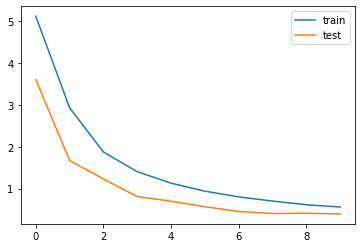

In [16]:
plt.plot(result_model['train_loss'],label = "train")
plt.plot(result_model['test_loss'],label = "test")
plt.legend()
plt.show()

In [17]:
valid_loss,valid_acc = test_step(model = model,test_dataloader = valid_dataloader,loss_fn = loss_fn,device = device)

In [25]:
def plot_result(model,valid_dataset,classes,random_seed = None):
    K = 12
    if random_seed :
        random.seed(random_seed)
    rand_idx = random.sample(range(len(valid_dataset)),k = K)
    class_idx = valid_dataset.class_to_idx
    plt.figure(figsize = (25,12))
    for i,idx in enumerate(rand_idx):
        img,label = valid_dataset[idx]
        label_pred = torch.argmax(model(img.unsqueeze(0).to(device)),dim = 1).item()
        plt.subplot(3,4,i+1)
        img = img.permute(1,2,0)
        if label == label_pred:
            plt.imshow(img)
            title_obj = plt.title(f"True class :{classes[label]}| Pred class: {classes[label_pred]}")
            plt.setp(title_obj, color='b')
        else:
            plt.imshow(img)
            title_obj = plt.title(f"True class :{classes[label]}| Pred class: {classes[label_pred]}")
            plt.setp(title_obj, color='r')
    plt.show()
    
    plot_result(model = model,valid_dataset = valid_dataset,classes = classes)

In [42]:
random_img_indx = random.choice(range(len(valid_df)))
label = valid_df.loc[random_img_indx,"labels"]
img = Image.open(valid_df.loc[random_img_indx,"filepaths"])
trans_img = test_transforms(img)

In [52]:
label_pred = torch.argmax(model(trans_img.unsqueeze(0).to(device)),dim = 1).item()
classes[label_pred] == label

True

Save Model

In [54]:
torch.save(model,'/kaggle/working/mobilenet_bird_classifer.pkl')

Load model and make prediction

In [21]:
model = torch.load('../mobilenet_bird_classifer.pkl')

In [22]:
test_transforms = transforms.Compose(
[
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [5]:
import os
os.listdir('extra_data')

['ALEXANDRINE PARAKEET.jpg',
 'Alexandrine-Parakeet.jpg',
 'hummingbird.jpg',
 'indigo_Bunting,_male.jpg',
 'Indigo_Bunting.jpg',
 'kingfisher.jpg',
 'NDIGO BUNTING.jpg',
 'parrot.jpg']

In [24]:
path = '../extra_data/ALEXANDRINE PARAKEET.jpg'
img = Image.open(path)
trans_img = test_transforms(img)

In [45]:
torch.argmax(model(trans_img.unsqueeze(0).to(device)),dim = 1).item()

1